In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/COVID_XRay_Project/models/covid_xray_model.h5')

In [2]:
import os
import random
import pandas as pd

train_dir = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/train"
val_dir   = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/val"

classes = ['COVID', 'Normal', 'Viral Pneumonia']
samples_per_class = 500 // len(classes)  # ≈ 166 par classe

filepaths = []
labels = []

for cls in classes:
    images = []

    # images de train
    images += [os.path.join(train_dir, cls, img)
               for img in os.listdir(os.path.join(train_dir, cls))]

    # images de val
    images += [os.path.join(val_dir, cls, img)
               for img in os.listdir(os.path.join(val_dir, cls))]

    selected = random.sample(images, samples_per_class)

    for img_path in selected:
        filepaths.append(img_path)
        labels.append(cls)

df = pd.DataFrame({
    "filename": filepaths,
    "class": labels
})

print("Images sélectionnées :", len(df))
df.head()


Images sélectionnées : 498


,filename,class
0,/content/drive/MyDrive/COVID_XRay_Project/data...,COVID
1,/content/drive/MyDrive/COVID_XRay_Project/data...,COVID
2,/content/drive/MyDrive/COVID_XRay_Project/data...,COVID
3,/content/drive/MyDrive/COVID_XRay_Project/data...,COVID
4,/content/drive/MyDrive/COVID_XRay_Project/data...,COVID


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (200, 200)
BATCH_SIZE = 16  # IMPORTANT pour éviter crash

datagen = ImageDataGenerator(rescale=1./255)



========== FOLD 1 ==========
Found 100 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Accuracy Fold 1 : 0.9500


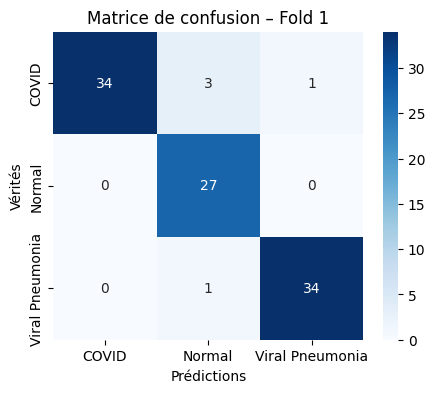


========== FOLD 2 ==========
Found 100 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Accuracy Fold 2 : 0.9400


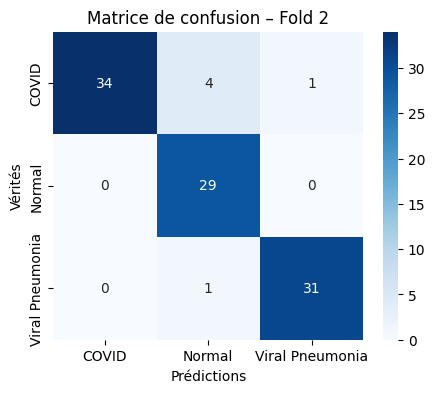


========== FOLD 3 ==========
Found 100 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Accuracy Fold 3 : 0.8900


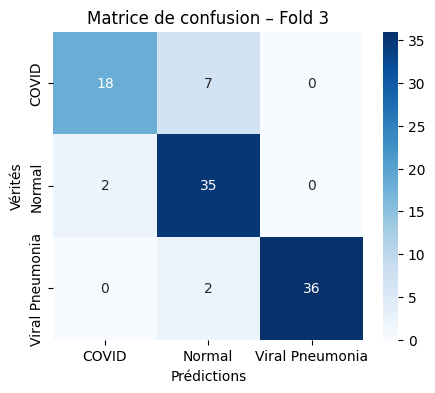


========== FOLD 4 ==========
Found 99 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Accuracy Fold 4 : 0.8485


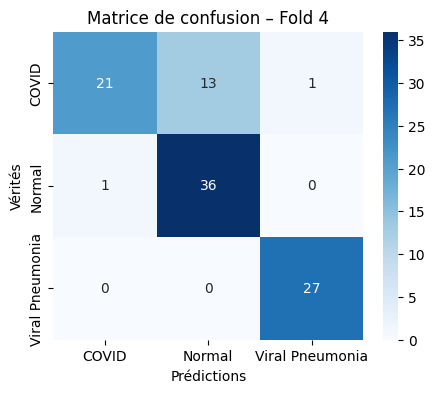


========== FOLD 5 ==========
Found 99 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Accuracy Fold 5 : 0.9495


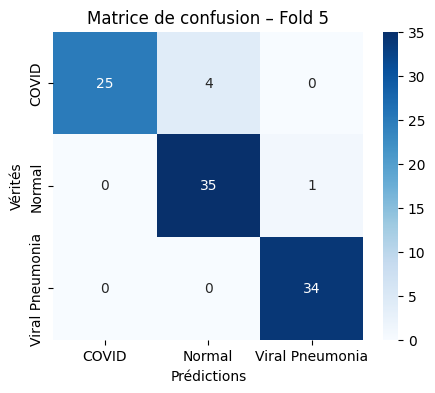

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model = load_model(
    "/content/drive/MyDrive/COVID_XRay_Project/models/covid_xray_model.h5"
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (_, val_idx) in enumerate(kf.split(df), 1):

    print(f"\n========== FOLD {fold} ==========")

    df_val = df.iloc[val_idx]

    val_gen = datagen.flow_from_dataframe(
        df_val,
        x_col="filename",
        y_col="class",
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    preds = model.predict(val_gen, verbose=0)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_gen.classes

    acc = accuracy_score(y_true, y_pred)
    fold_accuracies.append(acc)

    print(f"Accuracy Fold {fold} : {acc:.4f}")

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=classes,
                yticklabels=classes,
                cmap="Blues")
    plt.title(f"Matrice de confusion – Fold {fold}")
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités")
    plt.show()


In [5]:
import numpy as np

print("=================================")
print(f"Accuracy moyenne (5-fold) : {np.mean(fold_accuracies):.4f}")
print(f"Écart-type               : {np.std(fold_accuracies):.4f}")


Accuracy moyenne (5-fold) : 0.9156
Écart-type               : 0.0402
